## Load Stuff

In [18]:
import torch
from mario_gpt import MarioDataset, MarioLM, TrainingConfig, MarioGPTTrainer
from mario_gpt.utils import view_level, convert_level_to_png, join_list_of_list, characterize
from mario_gpt.flower_level import FLOWER_LEVEL


import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [19]:
#---
# load model and generate flowers
#---
img_length = 30

mario_lm = MarioLM(lm_path="../FlowerGPT", tokenizer_path="../FlowerGPT")
dataset = MarioDataset(mario_lm.tokenizer, level_string=FLOWER_LEVEL) # for token conversion


Using ../FlowerGPT lm


/home/gaiera/anaconda3/envs/nzb-gpt/lib/python3.9/site-packages/transformers-4.27.3-py3.9.egg/transformers/models/auto/modeling_auto.py:1295: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


Using ../FlowerGPT tokenizer


Token indices sequence length is longer than the specified maximum sequence length for this model (14000 > 1024). Running this sequence through the model will result in indexing errors


In [21]:
def token_to_rgb(token_array, token_dict, colors=None):
    # Create a reverse dictionary mapping token values to keys
    reverse_token_dict = {int(v.item()): k for k, v in token_dict.items()}

    # Use ascending integers as colors if not provided
    if colors is None:
        colors = [
            [0, 170, 0],       
            [185, 122, 87],      
            [255, 242, 0],     
            [191, 232, 242],   
        ]        

    # Create a dictionary mapping token values to colors
    color_dict = {token_value: color for token_value, color in zip(reverse_token_dict.keys(), colors)}

    # Function to map token values to colors or red if not in token_dict
    def map_to_color(token_value):
        return color_dict.get(token_value, [255, 0, 0])

    # Create a 3D array of RGB colors based on the token_array and color_dict using nested list comprehension
    rgb_array = np.array([[[map_to_color(token_value) for token_value in row] for row in token_array]])

    return rgb_array

def generated_to_rgb(generated_level):
    A = generated_level.level_tensor
    rot_img = np.rot90(A.reshape(img_length,14))
    return token_to_rgb(rot_img, dataset.token_dict)[0]

In [22]:
prompts = [" "]
generated_level = mario_lm.sample(
    prompts=prompts,
    num_steps=(14*img_length),
    temperature=1.0,
    use_tqdm=True
)
clear_output()

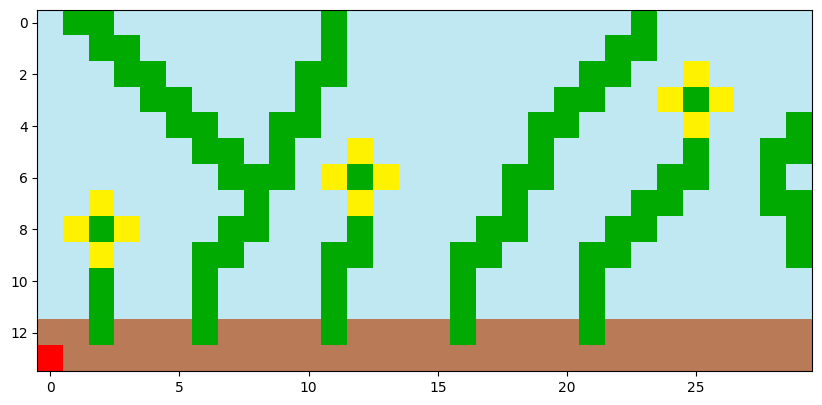

In [23]:
# Show Flowers
fig, ax = plt.subplots(figsize=(10, 10))
image = generated_to_rgb(generated_level)
ax.imshow(image)

## Test Prompts

In [24]:
from mario_gpt.flower_metric import count_flowers, calculate_crookedness_score

# Prompts
prompt_flower = ["no", "few", "some", "many"]
prompt_straight = ["not", "kinda", "very", "totally"]

i = 0
j = 0

# Generate
prompts = [f"{prompt_flower[i]} flowers, {prompt_straight[j]} straight"]
generated_level = mario_lm.sample(
    prompts=prompts,
    num_steps=(14*img_length),
    temperature=1.0,
    use_tqdm=True
)
clear_output()


# Test
image = generated_to_rgb(generated_level)
n_flowers = count_flowers(image)
straightness = calculate_crookedness_score(image)



Text(0.5, 1.0, 'Flowers: 2, Straightness: 151')

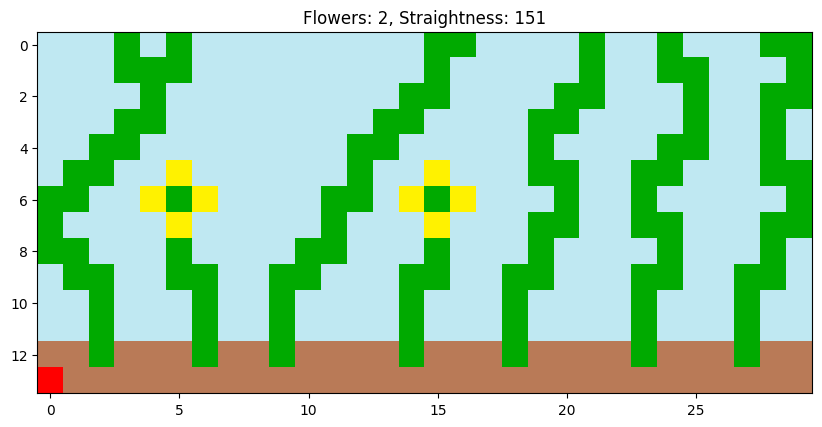

In [25]:
# Measure Result
fig, ax = plt.subplots(figsize=(10, 10))
image = generated_to_rgb(generated_level)
ax.imshow(image)
n_flowers = count_flowers(image)
straightness = calculate_crookedness_score(image)
ax.set_title(f'Flowers: {n_flowers}, Straightness: {straightness}')

## Generate Levels and Test as Line Plots

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Prompts
prompt_flower = ["no", "few", "some", "many"]
prompt_straight = ["not", "kinda", "very", "totally"]

n_rows = len(prompt_flower)
n_cols = len(prompt_straight)
n_iterations = 5
img_length = 50  # Set this to the desired image length

# Initialize lists to store scores for each iteration
flower_scores_iter = [[[] for _ in range(n_cols)] for _ in range(n_rows)]
straight_scores_iter = [[[] for _ in range(n_cols)] for _ in range(n_rows)]

# Generate and Test
for i in range(n_rows):
    for j in range(n_cols):
        for k in range(n_iterations):
            # Generate
            prompts = [f"{prompt_flower[i]} flowers, {prompt_straight[j]} straight"]
            generated_level = mario_lm.sample(
                prompts=prompts,
                num_steps=14*img_length,
                temperature=1.0,
                use_tqdm=True
            )
            clear_output()

            # Test
            image = generated_to_rgb(generated_level)
            n_flowers = count_flowers(image)
            straightness = calculate_crookedness_score(image)

            # Append scores to lists
            flower_scores_iter[i][j].append(n_flowers)
            straight_scores_iter[i][j].append(straightness)

shape: torch.Size([1, 7]), torch.Size([1, 8]) first: 56, last: 36:   1%|▊                                                                                                   | 6/700 [00:00<00:12, 56.85it/s]

Height: 14


shape: torch.Size([1, 513]), torch.Size([1, 514]) first: 56, last: 36:  73%|████████████████████████████████████████████████████████████████████▉                         | 513/700 [00:30<00:11, 16.90it/s]


KeyboardInterrupt: 

In [ ]:
# Display Box Plots
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Flower Scores

# Flower Scores
flower_data = [np.array(flower_scores_iter)[:, j, :].flatten() for j in range(n_cols)]
bp = ax[0].boxplot(flower_data)
ax[0].set_title("Number of Flowers")
ax[0].set_xlabel("Straightness")
ax[0].set_xticks(range(1, n_cols + 1))
ax[0].set_xticklabels(prompt_flower)
ax[0].set_ylabel("Flowers")

# Straightness Scores
straight_data = [np.array(straight_scores_iter)[:, j, :].flatten() for j in range(n_cols)]
bp = ax[1].boxplot(straight_data)
ax[1].set_title("Straightness")
ax[1].set_xlabel("Straightness")
ax[1].set_xticks(range(1, n_cols + 1))
ax[1].set_xticklabels(prompt_straight)
ax[1].set_ylabel("Straightness Score")

plt.show()

In [ ]:
# Display Heatmaps
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(flower_scores, annot=True, fmt=".2f", ax=ax[0], xticklabels=prompt_straight, yticklabels=prompt_flower, cmap="YlGnBu")
ax[0].set_title("Number of Flowers")
ax[0].set_xlabel("Straightness")
ax[0].set_ylabel("Flowers")

sns.heatmap(straight_scores, annot=True, fmt=".2f", ax=ax[1], xticklabels=prompt_straight, yticklabels=prompt_flower, cmap="YlGnBu")
ax[1].set_title("Straightness Scores")
ax[1].set_xlabel("Straightness")
ax[1].set_ylabel("Flowers")

plt.show()